# Run detectron2 on jpeg's of papers

Assumes you have:
1. Run the ocr_and_image_processing_batch.py file to generate the JPEGs
1. Run the `pull_check_makesense.ipynb` file to create annotation files, and then
1. Annotated on MakeSense.ai and downloaded those annotations
1. Run the `process_annotations.py` file to generate the yolo-style-XML anntation files

Also, specific for this version of detectron2, you need the weights trained on [the PubLayNet dataset](https://github.com/JPLeoRX/detectron2-publaynet).  You can do this in the command line with:

```
wget https://raw.githubusercontent.com/hpanwar08/detectron2/master/configs/DLA_mask_rcnn_R_101_FPN_3x.yaml
wget https://raw.githubusercontent.com/hpanwar08/detectron2/master/configs/DLA_mask_rcnn_R_50_FPN_3x.yaml
wget https://raw.githubusercontent.com/hpanwar08/detectron2/master/configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml
wget https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/Base-RCNN-FPN.yaml
```

Make sure you save these weights in a folder where you remember!

In [11]:
pages_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/Pages_htrc/RandomSingleFromPDFIndexed/'

In [7]:
detectron2_params_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/model_params/detectron2/'

# make sure these two are consistent!!!
detectron2_conf = 'DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml'
detectron2_weights = 'mask_rcnn_R_101_FPN_3x/model_final_trimmed.pth'

In [2]:
import argparse
import glob
import multiprocessing as mp
import numpy as np
import os
import tempfile
import time
import warnings
import cv2
import tqdm

from detectron2.config import get_cfg
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger

In [3]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [44]:
from glob import glob
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Rename classes for the PubLayNet dataset:

In [34]:
classes = ['text', 'title', 'list', 'table', 'figure']
MetadataCatalog.get("dla_val").thing_classes = classes

colors = [(0,0,255),(0,255,0), (255,0,0), (255,255,0), (255,0,255)]

General config file set up:

In [5]:
def setup_cfg(configfile, weightsfile, processingType='cpu', confidence_threshold=0.5):
    # load config from file and command-line arguments
    cfg = get_cfg()
    # To use demo for Panoptic-DeepLab, please uncomment the following two lines.
    # from detectron2.projects.panoptic_deeplab import add_panoptic_deeplab_config  # noqa
    # add_panoptic_deeplab_config(cfg)
    cfg.merge_from_file(configfile)
    argsList = ['MODEL.WEIGHTS',weightsfile, 'MODEL.DEVICE',processingType]
    #print(argsList)
    cfg.merge_from_list(argsList)
    # Set score_threshold for builtin models
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = confidence_threshold
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = confidence_threshold
    cfg.freeze()
    return cfg

In [9]:
config_file = detectron2_params_dir + detectron2_conf
weights_file = detectron2_params_dir + detectron2_weights

cfg = setup_cfg(config_file, weights_file)

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/Users/jnaiman/opt/anaconda3/envs/HTRCConf/lib/python3.8/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/Users/jnaiman/opt/anaconda3/envs/HTRCConf/lib/python3.8/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt


In [10]:
predictor = DefaultPredictor(cfg)

Start with just one to start:

In [14]:
pages = glob(pages_dir + '*')
#pages

In [37]:
ipage = 5

page = pages[ipage]

In [38]:
img = np.array(Image.open(page).convert('RGB'))

In [39]:
outputs = predictor(img)

In [40]:
outputs["instances"].pred_classes

tensor([0, 0, 4, 0, 1, 0, 0, 0, 0])

In [41]:
outputs["instances"].pred_boxes

Boxes(tensor([[ 194.7479, 1768.2535, 2234.9639, 2254.5801],
        [ 196.9969, 2290.3274, 2264.8093, 2776.0271],
        [ 169.7967,  748.4468, 2224.1606, 1724.8945],
        [ 640.7416,  683.1531, 1802.6869,  728.4691],
        [1159.3967,  602.3071, 1293.6146,  648.2304],
        [ 204.2317, 2028.5814, 2251.0879, 2070.5759],
        [ 143.5691,  178.8445, 2254.6838,  537.2009],
        [ 193.8410, 2551.0950, 2245.3210, 2592.2461],
        [ 251.7486, 2310.2588, 2266.6052, 2350.0283]]))

In [42]:
outputs["instances"].scores

tensor([0.9601, 0.9376, 0.8935, 0.8682, 0.7469, 0.6320, 0.6300, 0.5268, 0.5037])

Plot:

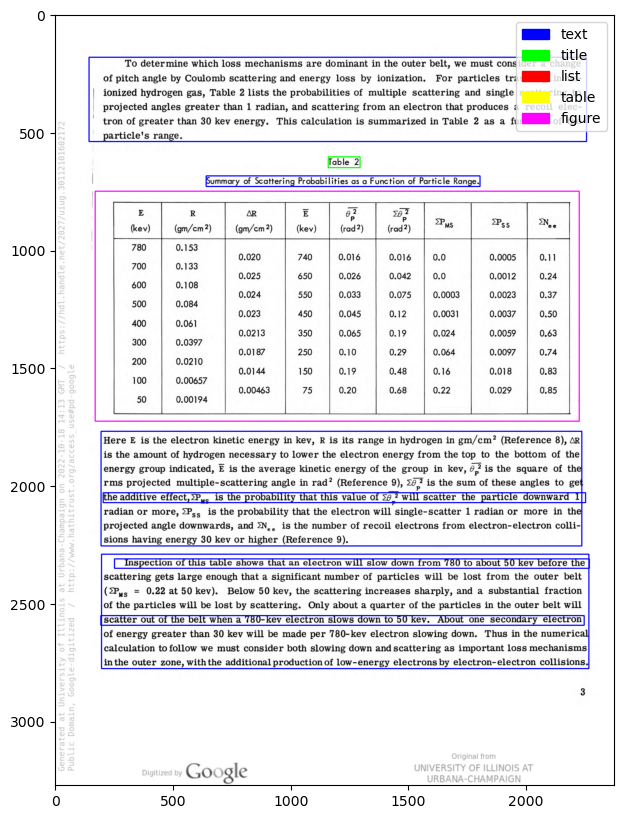

In [47]:
instances = outputs["instances"].to("cpu")
pred_boxes = instances.pred_boxes
scores = instances.scores
pred_classes = instances.pred_classes

fig, ax = plt.subplots(figsize=(20,10))

imgPlot = img.copy()

for c,b,s in zip(pred_classes, pred_boxes, scores):
    box = b.numpy()
    #print(box)
    xmin = int(round(box[0])); ymin = int(round(box[1]))
    xmax = int(round(box[2])); ymax = int(round(box[3]))
    cv.rectangle( imgPlot,  (xmin, ymin), (xmax, ymax), colors[c], 3 )
    #plt.legend(["blue", "orange"], loc=0, frameon=legend_drawn_flag)


patches = []
for c,cl in zip(classes,colors):
    patches.append(mpatches.Patch(color=(cl[0]/255.,cl[1]/255.,cl[2]/255.), label=c))

plt.legend(handles=patches)
ax.imshow(imgPlot)

plt.show()